# Lecture 17: Ensemble Learning and Random Forests

![](https://www.tensorflow.org/images/colab_logo_32px.png)
[Run in colab](https://colab.research.google.com/drive/1SNSqzKBuOnHfK_G_agJQtmE8y3WM2EhI)

In [1]:
import datetime
now = datetime.datetime.now()
print("Last executed: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Last executed: 2022-02-17 12:54:04


## Ensemble Learning

- *Wisdom of the Crowd* 
- The average from many predictors (or people) may be more accurate that the result from any single given predictor
- Group of predictors called an _ensemble_ 
- Even if individual predictors/classifiers are _weak_ (only slightly better than random), an ensemble can be _strong_ (high accuracy).
- Works in analogy to Monte Carlo method (e.g. flipping a coin N times leads to 50% probability of heads asymptotically).

Two approaches 
- Different predictors 
- Same predictor, different training sets

- Example are _Random Forests_ where Decision Trees are trained on random _*subsets*_ of the training data and then for each sample the assigned class is the one that gets the most _votes_ from the ensemble.

## Voting

![](https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture17_Images/votes1.png)

Majority wins (_hard_ voting) 

![](https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture17_Images/votes2.png)

Also _soft_ voting (see next slides and example)

In [2]:
#build a voting classifier in Scikit using three weaker classifiers

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# use moons dataset
X, y = make_moons(n_samples=500, noise=0.30, random_state=42) #X(features), y(classifications)

#split into training and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

#load three different classification algorithms, and initialise 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#(note will use the variable name in next slides)
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

In [3]:
from sklearn.ensemble import VotingClassifier

# voting classifier = logistic + random forest + SVC
# set up the voting classifier
voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='soft')

# classify using voting classifier (auto uses all the assigned invidiual classifiers)
voting_clf.fit(X_train, y_train);

In [4]:
# let's see how each individual classifier did:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf): #loop over classifiers
    clf.fit(X_train, y_train) #fit each one individually 
    y_pred = clf.predict(X_test) #make prediction 
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred)) #print the score
    
# voting classifier did better than 3 individual ones!

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


* Hard voting: frequency of the class, without weight taken into account.
* Soft voting: If all classifiers can estimate class probabilities (i.e. they have a predict_proba() method), use Scikit to predict highest class probability, averaged over all individual classifiers. 

* Soft often better than hard voting because it gives more weight to highly confident, but perhaps less frequent, votes.

### Bagging and Pasting 

Instead can use same predictor but different training sets. 

Two ways to create new training sets: 
- When sampling is performed with replacement, this method is called _bagging_ (short for bootstrap aggregating)
- When sampling is performed without replacement, it is called _pasting_ 

Big pro: 
- Trivially parallisable across nodes/CPU 


### Bagging 

Given a standard training set $D$ of size $n$, bagging generates $m>>n$ new training sets 
$D_{i}$, each of size $n'<n$, by sampling from $D$ uniformly and with replacement. 

By sampling _with replacement_, some observations may be repeated in each $D_{i}$.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture17_Images/bagging.png" alt="Drawing" style="width: 500px;"/>

### Pasting

Given a standard training set $D$ of size $n$, bagging generates $m>>n$ new training sets 
$D_{i}$, each of size $n'<n$, by sampling from $D$ uniformly and without replacement. 

By sampling _**without** replacement_, some observations may **not** be repeated in each $D_{i}$.


In [5]:
#example in Decision Trees using moons data from before
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

#make a single prediction using a decision tree
tree_clf = DecisionTreeClassifier(random_state=42) #setup classifier
tree_clf.fit(X_train, y_train) #train
y_pred_tree = tree_clf.predict(X_test) #predict
print(accuracy_score(y_test, y_pred_tree)) #test score

0.856


In [6]:
# SciKit Learn provides an easy way to do this using BaggingClassifier 
from sklearn.ensemble import BaggingClassifier #load the bagging classifier 


# Train ensemble of 500 Decision Tree classifiers
# each using 100 training instances - randomly sampled from training set
# with replacement. 

bag_clf = BaggingClassifier(
        DecisionTreeClassifier(random_state=42), #classifier to use
        n_estimators=500, #number of seperate classifiers
        max_samples=100, #number of training instances 
        bootstrap=True, # set to False for pasting instead of bagging.
        n_jobs=1, #number of cores to use -1 is 1
        random_state=42)

bag_clf.fit(X_train, y_train) #fit data 
y_pred = bag_clf.predict(X_test) #compare to prediction 
print(accuracy_score(y_test, y_pred))

0.904


In [7]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(handle, clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    handle.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        handle.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    handle.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    handle.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    handle.axis(axes)
    handle.set_xlabel(r"$x_1$", fontsize=18)
    handle.set_ylabel(r"$x_2$", fontsize=18, rotation=0)

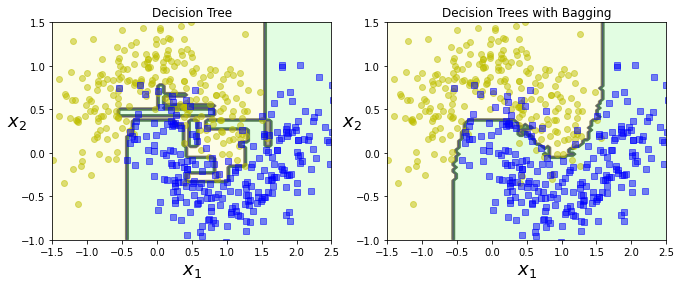

In [8]:
import numpy as np
import matplotlib.pyplot as plt

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

plot_decision_boundary(ax1, tree_clf, X, y), ax1.set_title("Decision Tree")

plot_decision_boundary(ax2, bag_clf, X, y), ax2.set_title("Decision Trees with Bagging");

### Bagging versus Pasting

* Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting, 
* But this also means that predictors end up being less correlated so the ensemble’s variance is reduced
* Overall, bagging often results in better models, which explains why it is generally preferred
* However, if you have spare time and CPU power you can use cross-validation to evaluate both bagging and pasting and select the one that works best.



* With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. 
* By default a ```BaggingClassifier``` samples $m$ training instances with replacement (```bootstrap = True```), where $m$ is the size of the training set
* Only about ~63% of the training instances are sampled on average for any given predictor 

* The remaining 37% of the training instances that are not sampled are called _out-of-bag (oob) instances_. Note that they are not the same 37% for all predictors.

* oob's will determine the accuracy of the ensemble predictor 

In [9]:
#use oob_score=True in Scikit to do automatic oob evaluation after training.

# oob_score_: predicts classifier results on test set.
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=1000,
    bootstrap=True, #using replacement 
    n_jobs=-1,
    oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [10]:
# did oob_score_ do a good job? ok, not great 
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.904

## Sampling _Features_ as well as Training Instances

Can also randomly sample the (set of) features themselves. Not only the training instances for a given set of features. 

### Random Patches

Sampling from _both_ instances and features is known as **Random Patches** method.

In SciKit-Learn this is using the ```max_features``` and ```bootstrap_features=True``` key words in ```BaggingClassifier```.



### Random Sub-Spaces

Keeping all training instances (i.e., ```bootstrap = False``` and ```max_samples = 1.0```) but sampling features only (i.e., ```bootstrap_features = True``` and/ or ```max_features``` smaller than 1.0) is called the **Random Subspaces method**

In [11]:
#random instances only
bag_clf = BaggingClassifier(
        DecisionTreeClassifier(random_state=42), 
        n_estimators=500, #number of seperate classifiers
        max_samples=100, #number of training instances 
        bootstrap=True, # set to False for pasting instead of bagging.
        n_jobs=-1, #number of cores to use
        random_state=42)

bag_clf.fit(X_train, y_train) #fit data 
y_pred = bag_clf.predict(X_test) #compare to prediction 
print(accuracy_score(y_test, y_pred))

0.904


In [12]:
#Random sub-space: features but not instances
bag_clf = BaggingClassifier(
        DecisionTreeClassifier(random_state=42), 
        n_estimators=500, #number of seperate classifiers
        max_samples=1.0, #number of training instances 
        bootstrap=False, # ***set to False 
        max_features=1.0,
        bootstrap_features=True, # *** setting to true for feature sampling 
        n_jobs=-1, #number of cores to use
        random_state=42)

bag_clf.fit(X_train, y_train) #fit data 
y_pred = bag_clf.predict(X_test) #compare to prediction 
print(accuracy_score(y_test, y_pred))

0.848


In [13]:
#Random Patches: random features and instances
bag_clf = BaggingClassifier(
        DecisionTreeClassifier(random_state=42), 
        n_estimators=500, #number of seperate classifiers
        max_samples=100, #number of training instances 
        bootstrap=True, # *** set to True 
        max_features=1.0,
        bootstrap_features=True, #*** setting to True for random patches
        n_jobs=-1, #number of cores to use
        random_state=42)

bag_clf.fit(X_train, y_train) #fit data 
y_pred = bag_clf.predict(X_test) #compare to prediction 
print(accuracy_score(y_test, y_pred))

0.904


## Random Forests
* RF = ensemble of Decision Trees
* We have actually been manually creating these in the previous examples explicitly!
* Typically trained via bagging
* ```RandomForestClassifier```: specially designed for DT classification
* ```RandomForestRegressor```: specially designed for regression

In [14]:
# Train an RF classifier with 500 trees limited to 16 max nodes each.
# splitter="random": tells RF to search for best feature among a random subset of features. 

bag_clf = BaggingClassifier(
    
    DecisionTreeClassifier(
        splitter="random", 
        max_leaf_nodes=16,   #*** leaf nodes ***
        random_state=42),
    
    n_estimators=500, #*** max trees ***
    max_samples=1.0, 
    bootstrap=True, #*** bagging *** 
    n_jobs=-1,
    random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.92


In [15]:
# allows for compressed syntax 
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(
    n_estimators=500, #*** number of trees
    max_leaf_nodes=16, #*** leaf nodes
    n_jobs=-1, 
    random_state=42)

rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_rf))

0.912


## Extremely Randomized Trees

When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). 

It is possible to make trees even more random by also using _random thresholds_ for each feature rather than searching for the _best possible thresholds_ (like regular Decision Trees do).

Implemented using ```ExtraTreesClassifier```

Need to try all these for a given problem

In [16]:
from sklearn.ensemble import ExtraTreesClassifier

rnd_clf = ExtraTreesClassifier(
    n_estimators=500, 
    max_leaf_nodes=16, 
    n_jobs=-1, 
    random_state=42)

rnd_clf.fit(X_train, y_train)
y_pred_et = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_et))

0.912


## Feature importance

* Important features likely to appear closer to root of tree
* Unimportant features likely to appear closer to leaves - if at all
* Scikit can find **average depth** of feature appearance across all trees in an RF as an assessment of the importance

* Accessed using ```feature_importances_``` variable in output
* Fraction of samples associated with each node

In [17]:
# rank features by importance in iris data (note switching to Iris from Moons)

from sklearn.datasets import load_iris
iris = load_iris()

X=iris["data"]
y=iris["target"]

rnd_clf = RandomForestClassifier(
    n_estimators=500, 
    n_jobs=-1, 
    random_state=42)

rnd_clf.fit(X,y)

#print out the importances 
for name, importance in zip(iris["feature_names"], rnd_clf.feature_importances_): 
        print(name, "=", importance) 

sepal length (cm) = 0.11249225099876375
sepal width (cm) = 0.02311928828251033
petal length (cm) = 0.4410304643639577
petal width (cm) = 0.4233579963547682


## Boosting

General term to mean combining several weak learners into a single strong learner.

The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are *AdaBoost* (adaptive boosting) and *gradient boosting*. 



## AdaBoost

Takes the points that are underfitted from previous fit to re-weight the points in a new training instance.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture17_Images/adaboost.png" alt="Drawing" style="width: 500px;"/>

AdaBoost pays more attention to training instances that predecessor underfitted - forces new predictors to concentrate more on the "hard cases".

Disadvantage: results depend on previous classifier (sequential), so algo cannot be parallelized. Not great for scaling.

In [18]:
# Plot decision boundaries of five predictors on moons dataset
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# use moons dataset
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

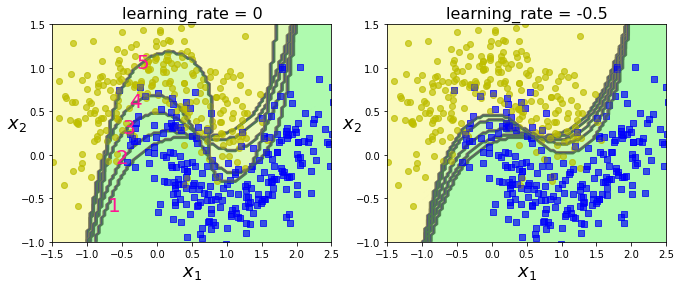

In [19]:
m = len(X_train)
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
for subplot, learning_rate in ((ax1, 1), (ax2, 0.5)): #change learning rate 
    sample_weights = np.ones(m)
    for i in range(5):
        
        svm_clf = SVC(kernel="rbf", C=0.05)  #use SVC classifications       
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train) #make prediction
        
        #*** points not predicted are given higher weight ***
        sample_weights[y_pred != y_train] *= (1 + learning_rate) 
        
        plot_decision_boundary(subplot, svm_clf, X, y, alpha=0.2)
        subplot.set_title("learning_rate = {}".format(learning_rate - 1), fontsize=16)

positions = [(-0.7, -0.65), (-0.6, -0.1), (-0.5, 0.25), (-0.4, 0.55), (-0.3, 1)]
for count, (x_pos, y_pos) in enumerate(positions):
    ax1.text(x_pos, y_pos, count+1, fontsize=20, color="deeppink")

### Gradient Boosting 

Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. 

However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the _residual errors_ made by the previous predictor.

Example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT).

In [20]:
from sklearn.tree import DecisionTreeRegressor

# training set: a noisy quadratic function
rnd.seed(42)
X = rnd.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * rnd.randn(100)

# train Regressor
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y);

In [21]:
# now train 2nd Regressor using errors made by 1st one.
y2 = y - tree_reg1.predict(X) #residual from the first fit (data-prediction)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2);

In [22]:
# now train 3rd Regressor using errors made by 2nd one.
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

X_new = np.array([[0.8]])

# now have ensemble w/ three trees.
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

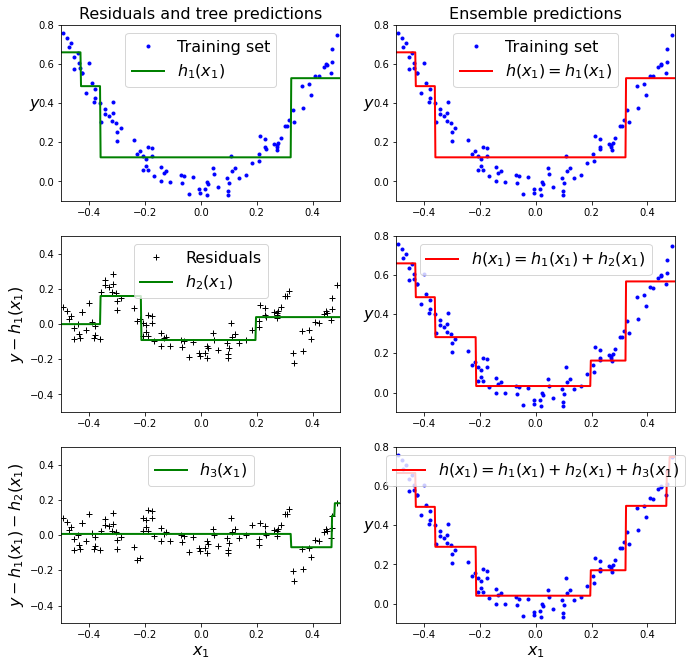

In [23]:
def plot_predictions(
    regressors, X, y, axes, 
    label=None, 
    style="r-", 
    data_style="b.", 
    data_label=None):
    
    x1 = np.linspace(axes[0], axes[1], 500)
    
    y_pred = sum(
        regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
            
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0);

The ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. 

You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.



In [24]:
#using inbuilt function 

from sklearn.ensemble import GradientBoostingRegressor 
#does same job as previous example

#first create test and train data
X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor( max_depth = 2, n_estimators = 3, learning_rate = 1.0) 
gbrt.fit(X_train, y_train)
y_pred_gbrt = gbrt.predict(X)

learning_rate param controls contribution of each tree. Low values (ex: 0.1) = need more trees in ensemble to fit training set, but predictions usually generalize better. (This is called shrinkage.)

However - want to avoid overfitting if there are too many trees. 

Use early stopping to achieve this.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

# train GRBR regressor with 120 trees
gbrt = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=120, 
    learning_rate=0.1, #set a low learning rate here
    random_state=42)

gbrt.fit(X_train, y_train)

# measure MSE validation error at each stage
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]

In [26]:
errors

[0.04842467352697948,
 0.0398597888673483,
 0.03302449818606398,
 0.02806997111382858,
 0.02339630299079877,
 0.01999633340157489,
 0.016779414028823922,
 0.014561646177542728,
 0.012926283191922123,
 0.011628235107060722,
 0.010081620906878525,
 0.009223451159716355,
 0.008300187610733945,
 0.007571087126619502,
 0.0070673893584988386,
 0.00653803624238612,
 0.006077383056688492,
 0.005771844373433087,
 0.005447427461093806,
 0.005157213176498388,
 0.004901417886199436,
 0.00471558200264981,
 0.00453619528497803,
 0.004448088027052898,
 0.004333234279094477,
 0.004321963799769775,
 0.004234959375173162,
 0.0041796582153428635,
 0.004143037112191631,
 0.004141154498016911,
 0.004128791217148569,
 0.004107175329801018,
 0.004014536589179014,
 0.0039256151671253105,
 0.003961416922115985,
 0.003975276013805897,
 0.003983348908362086,
 0.003978833421674226,
 0.003985927436966969,
 0.003942767915232586,
 0.003918667730764782,
 0.003965542510379509,
 0.003996847403739675,
 0.004023193747719

In [27]:
best_n_estimators = np.argmin(errors)
print(best_n_estimators)
min_error = errors[best_n_estimators]
print(min_error)

40
0.003918667730764782


**Exercises:** *You can now complete Exercise 1 in the exercises associated with this lecture.*

### Stacking (or Meta Learning)

Final method is to use stacking (stacked generalisation). 

Instead of using simple functions to perform agregation can actually use a learner to find the optimal combination. 

Done by a _blender_ or _meta learner_.


<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture17_Images/blender.png" alt="Drawing" style="width: 500px;"/>

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture17_Images/blender2.png" alt="Drawing" style="width: 500px;"/>

No current implementation of stacking in SciKit Learn